<a href="https://colab.research.google.com/github/crimama/DL_study/blob/main/U_net_basic_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 내용 정리 
- 파일 리스트 이용 해서 이미지 불러 오기 
- U- Net 사용 

**포인트**
- 이미지 사이즈 u-net에 맞춰야 함 
- x,y  모두 정규화 해야 함 
- x/255.astype(np.float)
- y/255.astype(np.int)

# 데이터 다운로드
- 출처 : https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

In [1]:
!rm -rf Lung_Segmentation.zip
!wget https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/Lung_Segmentation.zip

--2022-01-04 07:42:31--  https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/Lung_Segmentation.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/MDC_2021/master/material/deep_learning/Lung_Segmentation.zip [following]
--2022-01-04 07:42:31--  https://raw.githubusercontent.com/dhrim/MDC_2021/master/material/deep_learning/Lung_Segmentation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37648324 (36M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  35.90M  --.-KB/s    in 0.1s    

2022-01-04 07:42:32 (292 MB/s) -

In [ ]:
!rm -rf Lung_Segmentation
!unzip Lung_Segmentation.zip

## 풀린 데이터 파일 구조

```
Lung_segmentaiton/
  image/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
  label/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
```

## 데이터 확인 
- x-ray 사진을 입력으로 넣고, 폐 형태만 나오는 이미지를 출력으로 넣고 학습 
- test 이미지로 predict로 하게 되면 폐 형태 이미지만 출력 되게 됨 
- 이게 segmentation 

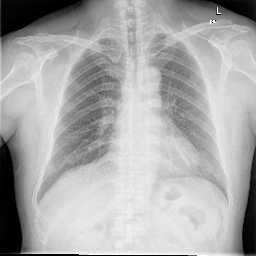

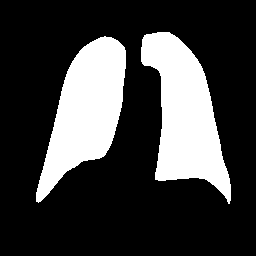

In [3]:
from IPython.display import Image, display

display(Image('./Lung_Segmentation/image/CHNCXR_0001_0.png'))
display(Image('./Lung_Segmentation/label/CHNCXR_0001_0.png'))

## 데이터 로드 
- 다운로드 받은 파일을 메모리에 올림 
- 이 부분은 우선 패스 
- 어쨋든 최종 목적은 파일 형태의 이미지 들을 메모리에 올려 train, test데이터를 만드는 것 

In [9]:
files[0]

'CHNCXR_0029_0.png'

In [8]:
os.path.splitext(files[0])[0]

'CHNCXR_0029_0'

In [47]:
from skimage.io import imread

# 이미지 불러 오기 
#1. 폴더 경로 불러오기 
data_path = "Lung_Segmentation"

#2. 이미지 폴더 안에 들어 있는 파일 리스트 불러 옴 
files = os.listdir(os.path.join(data_path, 'image')) #os.path.join은 그냥 단순히 + '/' + 역할 

#3. 파일 리스트를 이용 해 데이터 불러오기 
# i = 0
# temp = cv2.imread(os.path.join(data_path,'image',files[i]))
images = []
for i in files:
  temp = imread(os.path.join(data_path,'image',i))
  images.append(temp)
images = np.array(images)


#라벨 불러 오기 
data_path = "Lung_Segmentation"


#2. 라벨 폴더 안에 들어 있는 파일 리스트 불러 오기 
label_files = os.listdir(os.path.join(data_path,'label'))

#3.파일 리스트를 이용 해 이미지 읽어 오기 
labels = []
for i in label_files:
  temp = imread(os.path.join(data_path,'label',i))
  labels.append(temp)
#label  데이터 reshape
labels = np.array(labels).reshape(566,256,256,1)

In [48]:
print(images.shape, labels.shape)

(566, 256, 256, 3) (566, 256, 256, 1)


# 데이터 전처리 
- 정규화 
- 분할 

In [95]:
x = (images/255).astype(np.float)
y = (labels/255).astype(np.int)

In [96]:
from sklearn.model_selection import train_test_split
train_x,test_x, train_y,test_y = train_test_split(x,y, random_state = 42)

In [97]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(424, 256, 256, 3)
(424, 256, 256, 1)
(142, 256, 256, 3)
(142, 256, 256, 1)


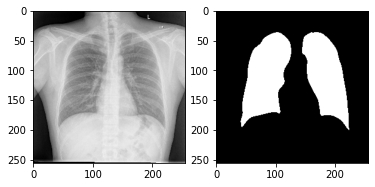

In [98]:
plt.subplot(1,2,1)
plt.imshow(train_x[0])
plt.subplot(1,2,2)
plt.imshow(train_y[0].squeeze(),'gray')
plt.show()

# U-net 
- biomedical 이미지 세그먼테이션을 위해 개발 된 CNN 네트워크 
- 이 네트워크는 오직 Convolutional 네트워크로 구성 
- 이 네트워크는 U자 형태의 확장, 대조적인 구조를 가짐 

## U-Net 모델 정의

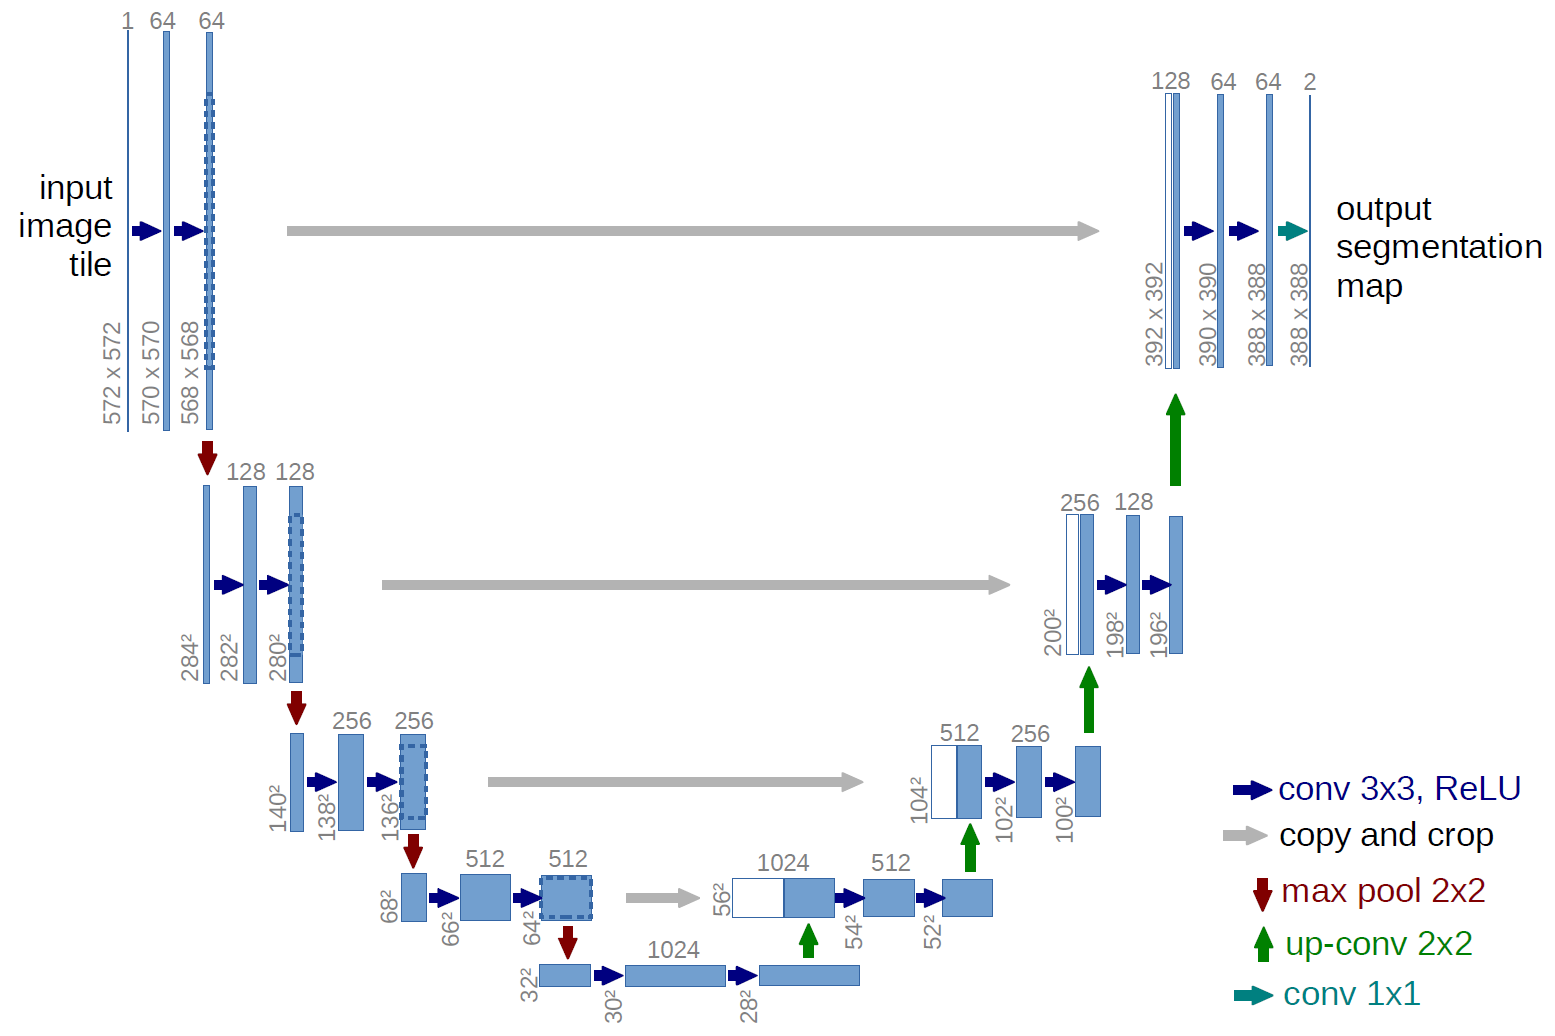

- U-Net은 Biomedical 분야에서 이미지 분할(Image Segmentation)을 목적으로 제안 된 End - to - End 방식의 Fully-convolutional Network 기반 모델 
- U-net은 이미지의 전반적인 컨텍스트 정보를 얻기 위한 네트워크와 정확한 지역화를 위한 네트워크가 대칭 형태로 구성 

- Contracting Path : 좌측부 
  - 입력 이미지의 Context 포착을 목적으로 구성 
- Expanding Path : 우측부
  - 세밀한 Localization을 위한 구성 
  - 높은 차원의 채널을 갖는 Up sampling 얕은 레이어의 특징맵을 결합 

이미지 생성이나 segmentation할 때 주로 사용 
- 내려가는 것 : down stream 
- 올라가는 방향 : up stream 
- 가운데 가장 아래 : 버틀렉

## U-Net 모듈 임포트

In [81]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)): #train_x, test_x 는 256,256,3의 shape을 가져야 함 
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3) # <---------- Conv4 를 넣음 
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3) # <------------ Conv 3를 넣음 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8) #<--- maxpooling과 반대의 역할을 함, 앞선 conv1과 반대의 작용을 하기 때문 
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) #<-------- 1장으로 만듬 

    return Model(inputs=[inputs], outputs=[conv10])

## 모델 컴파일 학습

In [99]:
# 모델 생성
model = unet()

# 모델 컴파일
model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
#loss = mse도 가능 하지만 binary_crossentropy가 훨씬 더 잘 됨 
#unet output의 형태가 1, activation = 'sigmoid'라 binary_crossentropy가 가능한 듯 
# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=20, batch_size=8, verbose=1)

Epoch 1/20
43/43 [==============================] - 11s 111ms/step - loss: 0.0507 - accuracy: 0.9376 - val_loss: 0.3904 - val_accuracy: 0.5508
Epoch 2/20
43/43 [==============================] - 4s 100ms/step - loss: 0.0205 - accuracy: 0.9750 - val_loss: 0.1792 - val_accuracy: 0.7938
Epoch 3/20
43/43 [==============================] - 4s 99ms/step - loss: 0.0186 - accuracy: 0.9768 - val_loss: 0.2271 - val_accuracy: 0.7522
Epoch 4/20
43/43 [==============================] - 4s 100ms/step - loss: 0.0180 - accuracy: 0.9772 - val_loss: 0.2178 - val_accuracy: 0.7607
Epoch 5/20
43/43 [==============================] - 4s 100ms/step - loss: 0.0175 - accuracy: 0.9775 - val_loss: 0.2380 - val_accuracy: 0.7490
Epoch 6/20
43/43 [==============================] - 4s 100ms/step - loss: 0.0166 - accuracy: 0.9787 - val_loss: 0.2444 - val_accuracy: 0.7490
Epoch 7/20
43/43 [==============================] - 4s 100ms/step - loss: 0.0161 - accuracy: 0.9792 - val_loss: 0.2440 - val_accuracy: 0.7490
Epoch 

## 학습 후 검증

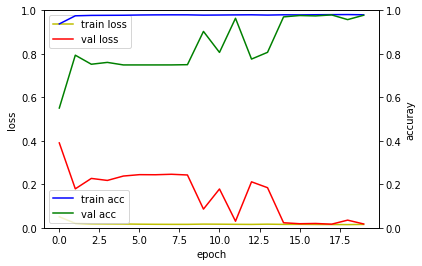

In [100]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## predicted vs test_y 비교 

In [101]:
y_ = model.predict(test_x)

In [86]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

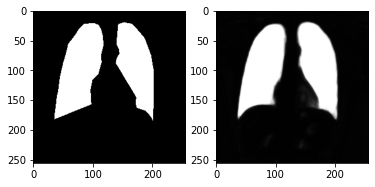

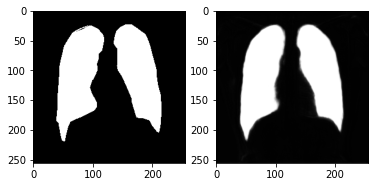

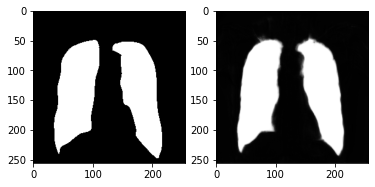

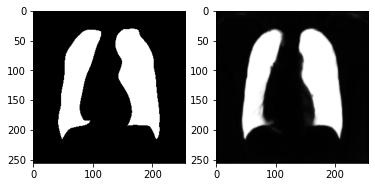

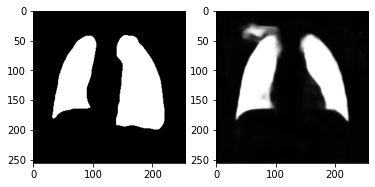

In [102]:
for i in range(5):
  plt.subplot(1,2,1)
  plt.imshow(test_y[i].squeeze(),'gray')
  plt.subplot(1,2,2)
  plt.imshow(y_[i].squeeze(),'gray')
  plt.show()